# Diffusion U-Net

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from fastcore.foundation import L
from fastprogress import progress_bar
from PIL import Image
import torchvision.transforms.functional as TF,torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.io import read_image, ImageReadMode
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.fid import *

In [ ]:
set_seed(1103, False)
mpl.rcParams['image.cmap'] = 'gray'
logging.disable(logging.WARNING)

In [ ]:
fm_x, fm_y = "image", "label"
name = "fashion_mnist"
ds = load_dataset(name)

In [ ]:
data_std = 0.667

In [ ]:
def scalings(std):
    total_var = (std  ** 2 + data_std ** 2)
    total_std = total_var.sqrt()
    c_skip = data_std ** 2 / total_var
    c_out = std * data_std / total_std
    c_in = 1 / total_std
    return c_skip, c_out, c_in

In [ ]:
def add_noise(x0):
    device = x0.device
    bs = x0.shape[0]

    sampled_stds = ((torch.randn((bs,), device=device) * 1.2) - 1.2).exp().clip(0.002, 80).reshape(-1, 1, 1, 1)
    c_skip, c_out, c_in = scalings(sampled_stds)
    
    noise = torch.randn(x0.shape, device=device)
    noise_part = sampled_stds * noise
    xt = x0 + noise_part

    input = c_in * xt
    target = (1 / c_out) * (x0 - c_skip * xt)
    
    return (input, sampled_stds.reshape(-1)), target

In [ ]:
def get_collate_ddpm():
    def _collate_ddpm(b):
        return add_noise(default_collate(b)[fm_x])
    return _collate_ddpm

collate_ddpm = get_collate_ddpm()

In [ ]:
def dl_ddpm(ds):
    return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=4)

In [ ]:
@inplace
def transformi2(b):
    b["image"] = [TF.pad(TF.to_tensor(i), padding=2, fill=0, padding_mode="constant") * 2 - 1 for i in b["image"]]
dst2 = ds.with_transform(transformi2)

In [ ]:
bs = 128
dls = DataLoaders(dl_ddpm(dst2["train"]), dl_ddpm(dst2["test"]))
xb, yb = next(iter(dls.train))

## Train

In [ ]:
def unet_conv(ni, nf, ks=3, stride=1, act=nn.SiLU, norm=None, bias=True):
    layers = []

    if act:
        layers.append(act())
    if norm:
        layers.append(norm(ni))
    layers.append(nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, bias=bias, padding=ks//2))

    return nn.Sequential(*layers)

In [ ]:
unet_conv(1, 2)(torch.empty((1,1, 2, 2))).shape

torch.Size([1, 2, 2, 2])

In [ ]:
class UnetResBlock(nn.Module):
    def __init__(self, ni, nf=None, ks=3, act=nn.SiLU, norm=nn.BatchNorm2d):
        super().__init__()
        if nf is None:
            nf = ni

        self.convs = nn.Sequential(
            unet_conv(ni, nf, ks=ks, act=act, norm=norm),
            unet_conv(nf, nf, ks=ks, act=act, norm=norm)
        )
        if ni == nf:
            self.id_conv = fc.noop
        else:
            self.id_conv = unet_conv(ni, nf, ks=1, act=None)
    
    def forward(self, x):
        return self.convs(x) + self.id_conv(x)

In [ ]:
UnetResBlock(1,2)(torch.empty(1,1,2,2)).shape

torch.Size([1, 2, 2, 2])

In [ ]:
class SaveModule:
    def forward(self, x, *args, **kwargs):
        self.output = super().forward(x, *args, **kwargs)
        return self.output

In [ ]:
class SaveResBlock(SaveModule, UnetResBlock):
    ...

class SaveConv(SaveModule, nn.Conv2d):
    ...

In [ ]:
_=SaveResBlock(1,2)
_(torch.empty(1,1,2,2))
print(_.output.shape)
del _

torch.Size([1, 2, 2, 2])


In [ ]:
def down_block(ni, nf, add_down=True, num_layers=1):
    layers = [SaveResBlock(ni, nf)]
    for i in range(1, num_layers):
        layers.append(SaveResBlock(nf, nf))
    if add_down:
        layers.append(SaveConv(nf, nf, kernel_size=3, stride=2, padding=1))
    return nn.Sequential(*layers)

In [ ]:
down_block(1,2,num_layers=3)(torch.empty((1,1,2,2))).shape

torch.Size([1, 2, 1, 1])

In [ ]:
def upsample(nf):
    return nn.Sequential(
        nn.UpsamplingNearest2d(scale_factor=2),
        nn.Conv2d(nf, nf, kernel_size=3, padding=1)
    )

In [ ]:
upsample(1)(torch.empty((1,1,1,1))).shape

torch.Size([1, 1, 2, 2])

In [ ]:
class UpBlock(nn.Module):
    def __init__(self, ni, prev_nf, nf, add_up=True, num_layers=2):
        super().__init__()
        blocks = [UnetResBlock(prev_nf + nf, nf)]
        for i in range(1, num_layers - 1):
            blocks.append(UnetResBlock(nf + nf, nf))
        blocks.append(UnetResBlock(nf + ni, nf))
        self.blocks = nn.Sequential(*blocks)
        
        if add_up:
            self.up = upsample(nf)
        else:
            self.up = fc.noop

    def forward(self, x, ups):
        for i, block in enumerate(self.blocks):
            x = block(torch.cat((x, ups[i]), dim=1))
        return self.up(x)

In [ ]:
UpBlock(3,2,4, True, 3).eval()(torch.empty(1,4,1,1), [torch.empty(1,2,1,1), torch.empty(1,4,1,1), torch.empty(1,3,1,1)]).shape

torch.Size([1, 4, 2, 2])

In [ ]:
class UNet2DModel(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, nfs=(224, 448, 672, 896), num_layers=1):
        super().__init__()

        self.pre_down = nn.Conv2d(in_channels, nfs[0], kernel_size=3, padding=1)
        self.down = nn.Sequential(*[
            down_block(
                nfs[max(0, i - 1)], nfs[i], 
                add_down=(i != len(nfs) - 1), num_layers=num_layers
            ) for i in range(len(nfs))
        ])

        self.pre_up = UnetResBlock(nfs[-1])
        self.up = nn.Sequential(*[
            UpBlock(
                nfs[max(0, i - 1)], nfs[min(len(nfs) - 1, i + 1)], nfs[i],
                add_up=(i != 0), num_layers=num_layers+1
            ) for i in range(len(nfs) - 1, -1, -1)
        ])
        self.post_up = unet_conv(nfs[0], out_channels, norm=nn.BatchNorm2d)

    def forward(self, x):
        x = self.pre_down(x[0])
        down_act = []
        new = [x]
        x = self.down(x)
        for b in self.down:
            for s in b:
                new.append(s.output)
            down_act.append(new[:-1])
            new = [new[-1]]
        down_act[-1].append(new[0])

        x = self.pre_up(x)
        for i, b in enumerate(self.up):
            x = b(x, down_act[-i - 1][::-1])
        x = self.post_up(x)

        return x

In [ ]:
UNet2DModel(1,3,(2,4,6,8),num_layers=4)((torch.empty(1,1,16,16), 1)).shape

torch.Size([1, 3, 16, 16])

In [ ]:
init_w = partial(init_weights, leak=0.1)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB()]
opt_func = partial(optim.AdamW, eps=1e-4)

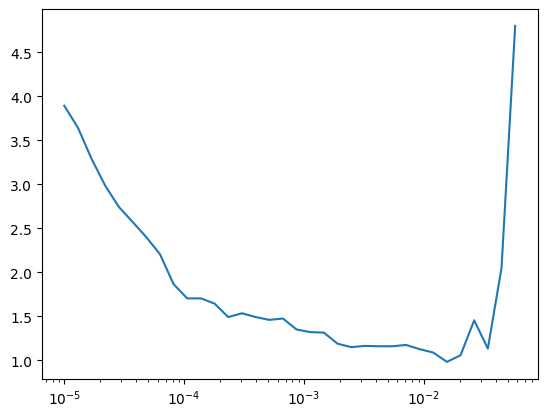

In [ ]:
set_seed(1103, False)
TrainLearner(
    UNet2DModel(in_channels=1, out_channels=1, nfs=(32, 64, 128, 256), num_layers=2).apply(init_w),
    dls, F.mse_loss, lr=0.1, cbs=[DeviceCB()], opt_func=opt_func
).lr_find()

loss,epoch,train
0.885,0,train
0.772,0,valid
0.371,1,train
0.248,1,valid
0.222,2,train
0.209,2,valid
0.196,3,train
0.201,3,valid
0.185,4,train
0.187,4,valid


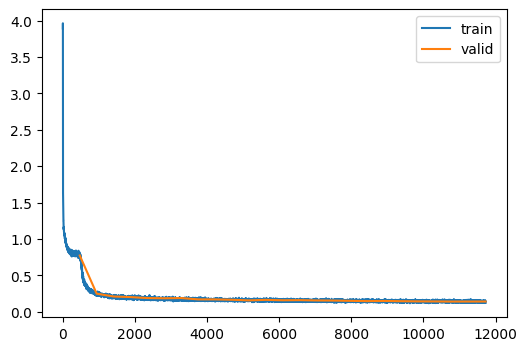

In [ ]:
set_seed(1103, False)
lr = 0.005
epochs = 25
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))
cbs = [DeviceCB(), ProgressCB(True), MetricsCB(), sched]

model = UNet2DModel(in_channels=1, out_channels=1, nfs=(32, 64, 128, 256), num_layers=2).apply(init_w)

opt_func = partial(optim.AdamW, eps=1e-4)

learn = TrainLearner(model, dls, F.mse_loss, lr=lr, cbs=cbs, opt_func=opt_func)
learn.fit(epochs)

In [ ]:
model_path = Path("models")
model_path.mkdir(exist_ok=True)
torch.save(learn.model, model_path / "26_diffusion_unet_25.pkl")

In [ ]:
model_path = Path("models")
model = torch.load(model_path / "26_diffusion_unet_25.pkl").cuda()

In [ ]:
bs2 = 256

In [ ]:
def sigmas_karras(n, sigma_min=0.01, sigma_max=80, rho=7, device="cpu"):
    i = torch.linspace(0, 1, n)
    min_scale = sigma_min ** (1 / rho)
    max_scale = sigma_max ** (1 / rho)
    sigmas = (max_scale + i * (min_scale - max_scale)) ** rho
    sigmas = torch.cat((sigmas, tensor([0.]))).to(device=device)
    return sigmas

def denoise(model, x, std):
    c_skip, c_out, c_in = scalings(std)
    predicted = model((x * c_in, std))
    return c_skip * x + c_out * predicted

def sample_euler(x, sigs, i, model):
    with torch.no_grad():
        sig1, sig2 = sigs[i], sigs[i + 1]
        x0 = denoise(model, x, sig1)
        mult = (sig2 - sig1) / sig1
        x_prev = x * (1 + mult) - x0 * mult
    return x_prev

def sample(sampler, model, steps=100, sigma_max=80, shape=(bs2, 1, 32, 32), **kwargs):
    device = next(model.parameters()).device
    x = torch.randn(shape, device=device) * sigma_max
    sigmas = sigmas_karras(steps, sigma_max=sigma_max, device=device)
    with torch.no_grad():
        for step in progress_bar(range(len(sigmas) - 1)):
            x = sampler(x, sigmas, step, model, **kwargs)
    return x

In [ ]:
set_seed(1103, False)
samples = sample(sample_euler, model)
samples.min(), samples.max()

(tensor(-1.2593, device='cuda:0'), tensor(1.2073, device='cuda:0'))

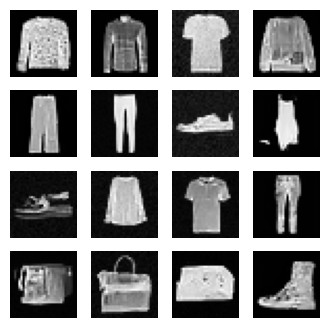

In [ ]:
show_images(samples[:16], imsize=1);

In [ ]:
dls2 = DataLoaders.from_dd(dst2, bs2)
xb, yb = next(iter(dls2.train))

fid_model = torch.load('models/14_aug_for_fid.pkl')
del fid_model[8]
del fid_model[7]

image_eval = ImageEval(fid_model, dls2, cbs=[DeviceCB()])
xb.min(), xb.max()

(tensor(-1.), tensor(1.))

In [ ]:
image_eval.fid(samples), image_eval.kid(samples)

(24.2117919921875, 0.04925870895385742)

In [ ]:
samples = samples.clip(-1, 1)
image_eval.fid(samples), image_eval.kid(samples)

(22.8062744140625, 0.04024171829223633)

In [ ]:
xb, yb = next(iter(dls2.train))
image_eval.fid(xb), image_eval.kid(xb)

(15.4024658203125, -0.006153106689453125)

## Timesteps

https://arxiv.org/abs/1706.03762

In [ ]:
emb_dim = 16
tsteps = torch.linspace(-10, 10, 100)
max_period = 10000

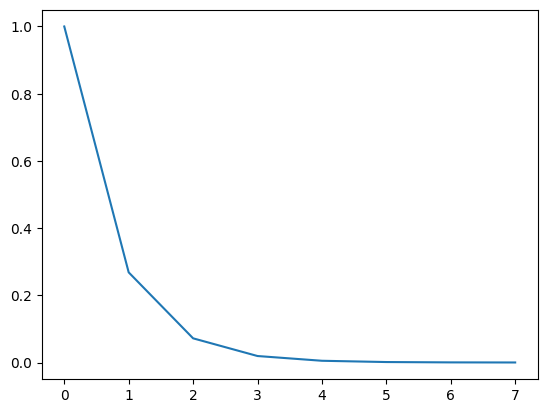

In [ ]:
mult = 1 / max_period ** torch.linspace(0, 1, emb_dim // 2)
plt.plot(mult);

In [ ]:
emb_t = tsteps[:, None] * mult[None]
emb_t.shape

torch.Size([100, 8])

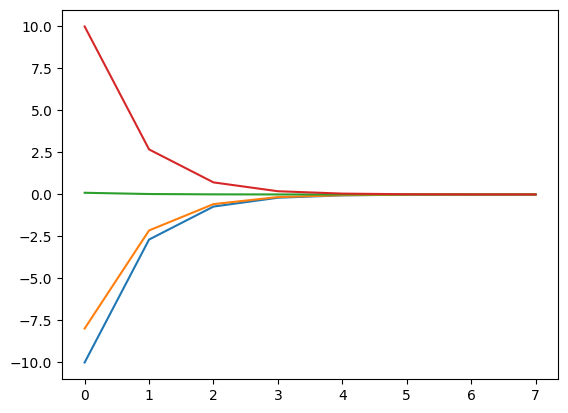

In [ ]:
plt.plot(emb_t[0]);
plt.plot(emb_t[10]);
plt.plot(emb_t[50]);
plt.plot(emb_t[99]);

In [ ]:
emb = torch.cat((torch.sin(emb_t), torch.cos(emb_t)), dim=1)
emb.shape

torch.Size([100, 16])

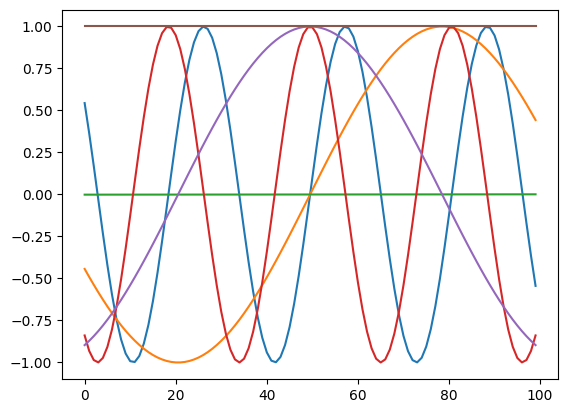

In [ ]:
plt.plot(emb[:, 0]);
plt.plot(emb[:, 1]);
plt.plot(emb[:, 7]);
plt.plot(emb[:, 8]);
plt.plot(emb[:, 9]);
plt.plot(emb[:, 15]);

In [ ]:
def timestamp_embedding(tsteps, emb_dim, max_period):
    mult = 1 / max_period ** torch.linspace(0, 1, emb_dim // 2, device=tsteps.device)
    emb_t = tsteps[:, None] * mult[None]
    emb = torch.cat((torch.sin(emb_t), torch.cos(emb_t)), dim=1)
    return emb

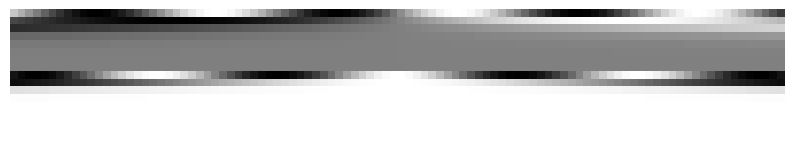

In [ ]:
show_image(timestamp_embedding(tsteps, emb_dim, 10000).T, figsize=(10,10));

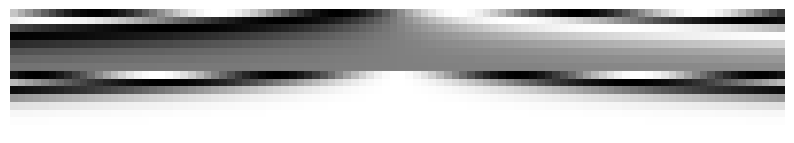

In [ ]:
show_image(timestamp_embedding(tsteps, emb_dim, 100).T, figsize=(10,10));

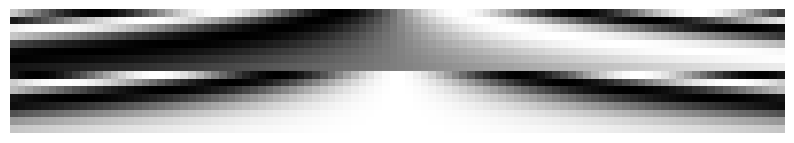

In [ ]:
show_image(timestamp_embedding(tsteps, emb_dim, 10).T, figsize=(10,10));

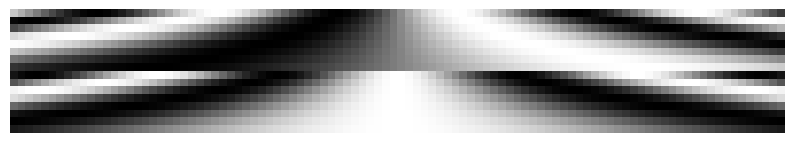

In [ ]:
show_image(timestamp_embedding(tsteps, emb_dim, 4).T, figsize=(10,10));

## Timestep Model

In [ ]:
def lin(ni, nf, act=nn.SiLU, norm=None, bias=True):
    layers = []

    if act:
        layers.append(act())
    if norm:
        layers.append(norm(ni))
    layers.append(nn.Linear(ni, nf, bias=bias))
    return nn.Sequential(*layers)

In [ ]:
lin(4,2)(torch.empty(3,4)).shape

torch.Size([3, 2])

In [ ]:
class EmbResBlock(nn.Module):
    def __init__(self, n_emb, ni, nf=None, ks=3, act=nn.SiLU, norm=nn.BatchNorm2d):
        super().__init__()
        if nf is None:
            nf = ni

        self.emb_layer = lin(n_emb, nf * 2)
        self.nf = nf
        self.convs = nn.Sequential(
            unet_conv(ni, nf, ks=ks, act=act, norm=norm),
            unet_conv(nf, nf, ks=ks, act=act, norm=norm)
        )
        if ni == nf:
            self.id_conv = fc.noop
        else:
            self.id_conv = unet_conv(ni, nf, ks=1, act=None)

    def forward(self, x):
        x, t = x
        init_x = x
        x = self.convs[0](x)
        emb = self.emb_layer(t)[..., None, None]
        x = x * (1 + emb[:, :self.nf])  + emb[:, self.nf:]
        x = self.convs[1](x)
        return x + self.id_conv(init_x)

In [ ]:
EmbResBlock(8, 2)((torch.empty(1,2,4,4), torch.empty(1,8))).shape

torch.Size([1, 2, 4, 4])

In [ ]:
from functools import wraps

In [ ]:
def saved(m, blk):
    forward = m.forward
    @wraps(m.forward)
    def f(*args, **kwargs):
        output = forward(*args, **kwargs)
        blk.output.append(output)
        return output
    m.forward = f
    return m

In [ ]:
_ = EmbResBlock(8, 2)
_.output = []
_ = saved(_, _)
_((torch.empty(1,2,4,4), torch.empty(1,8)))
print(len(_.output), _.output[0].shape)
del _

1 torch.Size([1, 2, 4, 4])


In [ ]:
class DownBlock(nn.Module):
    def __init__(self, n_emb, ni, nf, add_down=True, num_layers=1):
        super().__init__()

        layers = [saved(EmbResBlock(n_emb, ni, nf), self)]
        for i in range(1, num_layers):
            layers.append(saved(EmbResBlock(n_emb, nf, nf), self))
        self.layers = nn.Sequential(*layers)

        self.down = fc.noop
        if add_down:
            self.down = saved(
                nn.Conv2d(nf, nf, kernel_size=3, stride=2, padding=1),
                self
            )

    def forward(self, x):
        self.output = []
        x, t = x
        for l in self.layers:
            x = l((x, t))
        x = self.down(x)
        return x

In [ ]:
_ = DownBlock(8, 2, 3, num_layers=2)
_.output = []
_((torch.empty(1,2,4,4), torch.empty(1,8)))
print(len(_.output))
for o in _.output:
    print(o.shape)

3
torch.Size([1, 3, 4, 4])
torch.Size([1, 3, 4, 4])
torch.Size([1, 3, 2, 2])


In [ ]:
class UpBlock(nn.Module):
    def __init__(self, n_emb, ni, prev_nf, nf, add_up=True, num_layers=2):
        super().__init__()
        blocks = [EmbResBlock(n_emb, prev_nf + nf, nf)]
        for i in range(1, num_layers - 1):
            blocks.append(EmbResBlock(n_emb, nf + nf, nf))
        blocks.append(EmbResBlock(n_emb, nf + ni, nf))
        self.blocks = nn.Sequential(*blocks)
        
        if add_up:
            self.up = upsample(nf)
        else:
            self.up = fc.noop

    def forward(self, x, ups):
        x, t = x
        for i, block in enumerate(self.blocks):
            x = block((torch.cat((x, ups[i]), dim=1), t))
        return self.up(x)

In [ ]:
UpBlock(8,3,2,4, True, 3).eval()(
    (torch.empty(1,4,1,1), torch.empty(1, 8)),
    [torch.empty(1,2,1,1), torch.empty(1,4,1,1), torch.empty(1,3,1,1)]
).shape

torch.Size([1, 4, 2, 2])

In [ ]:
class EmbUNetModel(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, nfs=(224, 448, 672, 896), num_layers=1):
        super().__init__()

        self.n_emb_t = n_emb_t = nfs[0]
        self.n_emb = n_emb = nfs[0]

        self.pre_down = nn.Conv2d(in_channels, nfs[0], kernel_size=3, padding=1)
        self.pre_down_emb = nn.Sequential(
            lin(n_emb_t, n_emb, act=False),
            lin(n_emb, n_emb)
        )
        self.down = nn.Sequential(*[
            DownBlock(
                n_emb,
                nfs[max(0, i - 1)], nfs[i], 
                add_down=(i != len(nfs) - 1), num_layers=num_layers
            ) for i in range(len(nfs))
        ])

        self.pre_up = UnetResBlock(nfs[-1])
        self.up = nn.Sequential(*[
            UpBlock(
                n_emb,
                nfs[max(0, i - 1)], nfs[min(len(nfs) - 1, i + 1)], nfs[i],
                add_up=(i != 0), num_layers=num_layers+1
            ) for i in range(len(nfs) - 1, -1, -1)
        ])
        self.post_up = unet_conv(nfs[0], out_channels, norm=nn.BatchNorm2d)

    def forward(self, x):
        x, t = x
        emb_t = timestamp_embedding(t, self.n_emb_t, 10)
        
        x = self.pre_down(x)
        emb = self.pre_down_emb(emb_t)
        down_act = []
        new = [x]

        for b in self.down:
            x = b((x, emb))
        for b in self.down:
            new = [new[0], *b.output[:-1]]
            down_act.append(new)
            new = [b.output[-1]]
        down_act[-1].append(new[0])

        x = self.pre_up(x)
        for i, b in enumerate(self.up):
            x = b((x, emb), down_act[-i - 1][::-1])
        x = self.post_up(x)

        return x

In [ ]:
EmbUNetModel(1,3,(2,4,6,8),num_layers=4)((torch.empty(1,1,16,16), torch.empty(1))).shape

torch.Size([1, 3, 16, 16])

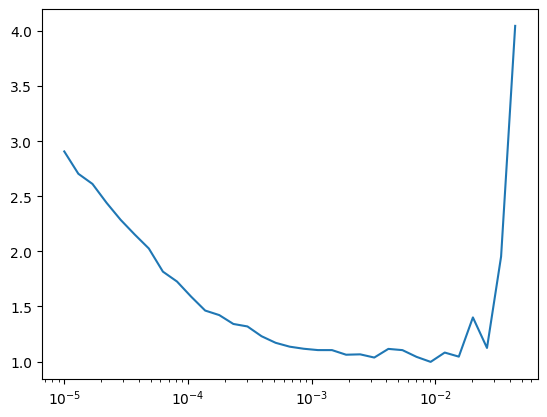

In [ ]:
set_seed(1103, False)
TrainLearner(
    EmbUNetModel(in_channels=1, out_channels=1, nfs=(32, 64, 128, 256), num_layers=2).apply(init_w),
    dls, F.mse_loss, lr=0.1, cbs=[DeviceCB()], opt_func=opt_func
).lr_find()

loss,epoch,train
0.863,0,train
0.769,0,valid
0.419,1,train
0.231,1,valid
0.204,2,train
0.198,2,valid
0.184,3,train
0.200,3,valid
0.173,4,train
0.178,4,valid


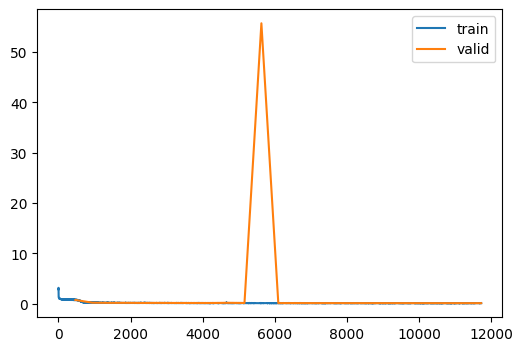

In [ ]:
set_seed(1103, False)
lr = 0.005
epochs = 25
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))
cbs = [DeviceCB(), ProgressCB(True), MetricsCB(), sched]

model = EmbUNetModel(in_channels=1, out_channels=1, nfs=(32, 64, 128, 256), num_layers=2).apply(init_w)

opt_func = partial(optim.AdamW, eps=1e-4)

learn = TrainLearner(model, dls, F.mse_loss, lr=lr, cbs=cbs, opt_func=opt_func)
learn.fit(epochs)

In [ ]:
# model_path = Path("models")
# model_path.mkdir(exist_ok=True)
# torch.save(learn.model, model_path / "26_diffusion_emb_unet_25.pkl")

## Sampling

In [ ]:
# model_path = Path("models")
# model = torch.load(model_path / "26_diffusion_emb_unet_25.pkl").cuda()

In [ ]:
bs2 = 256

def sigmas_karras(n, sigma_min=0.01, sigma_max=80, rho=7, device="cpu"):
    i = torch.linspace(0, 1, n)
    min_scale = sigma_min ** (1 / rho)
    max_scale = sigma_max ** (1 / rho)
    sigmas = (max_scale + i * (min_scale - max_scale)) ** rho
    sigmas = torch.cat((sigmas, tensor([0.]))).to(device=device)
    return sigmas

def denoise(model, x, std):
    c_skip, c_out, c_in = scalings(std)
    std = std.unsqueeze(0)
    predicted = model((x * c_in, std))
    return c_skip * x + c_out * predicted

def sample_euler(x, sigs, i, model):
    with torch.no_grad():
        sig1, sig2 = sigs[i], sigs[i + 1]
        x0 = denoise(model, x, sig1)
        mult = (sig2 - sig1) / sig1
        x_prev = x * (1 + mult) - x0 * mult
    return x_prev

def sample(sampler, model, steps=100, sigma_max=80, shape=(bs2, 1, 32, 32), **kwargs):
    device = next(model.parameters()).device
    x = torch.randn(shape, device=device) * sigma_max
    sigmas = sigmas_karras(steps, sigma_max=sigma_max, device=device)
    with torch.no_grad():
        for step in progress_bar(range(len(sigmas) - 1)):
            x = sampler(x, sigmas, step, model, **kwargs)
    return x

In [ ]:
set_seed(1103, False)
samples = sample(sample_euler, model, steps=10)
samples.min(), samples.max()

(tensor(-1.0262, device='cuda:0'), tensor(1.0562, device='cuda:0'))

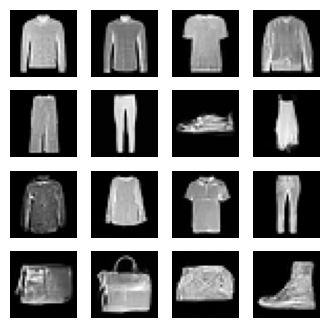

In [ ]:
show_images(samples[:16], imsize=1);

In [ ]:
set_seed(1103, False)
samples = sample(sample_euler, model, steps=25)
samples.min(), samples.max()

(tensor(-1.1192, device='cuda:0'), tensor(59.0475, device='cuda:0'))

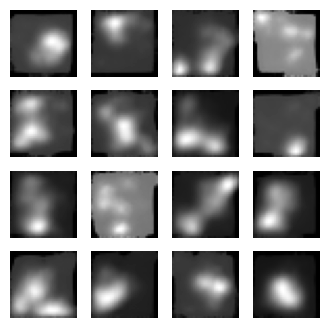

In [ ]:
show_images(samples[:16], imsize=1);

In [ ]:
set_seed(1103, False)
samples = sample(sample_euler, model, steps=25, sigma_max=60.)
samples.min(), samples.max()

(tensor(-1.0474, device='cuda:0'), tensor(1.1020, device='cuda:0'))

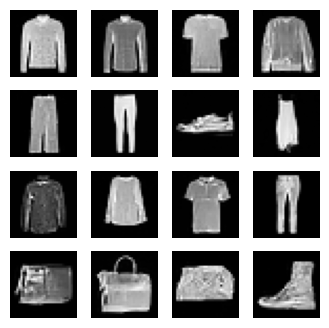

In [ ]:
show_images(samples[:16], imsize=1);

In [ ]:
set_seed(1103, False)
samples = sample(sample_euler, model, steps=100, sigma_max=50.)
samples.min(), samples.max()

(tensor(-1.0742, device='cuda:0'), tensor(1.1274, device='cuda:0'))

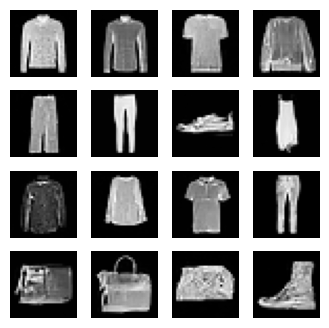

In [ ]:
show_images(samples[:16], imsize=1);

In [ ]:
dls2 = DataLoaders.from_dd(dst2, bs2)
xb, yb = next(iter(dls2.train))

fid_model = torch.load('models/14_aug_for_fid.pkl')
del fid_model[8]
del fid_model[7]

image_eval = ImageEval(fid_model, dls2, cbs=[DeviceCB()])
xb.min(), xb.max()

(tensor(-1.), tensor(1.))

In [ ]:
image_eval.fid(samples), image_eval.kid(samples)

(26.7581787109375, 0.05671215057373047)

In [ ]:
samples = samples.clip(-1, 1)
image_eval.fid(samples), image_eval.kid(samples)

(26.675048828125, 0.056107521057128906)

In [ ]:
xb, yb = next(iter(dls2.train))
image_eval.fid(xb), image_eval.kid(xb)

(15.4024658203125, -0.006153106689453125)